___

In [18]:
# Import libraries to be used

# Warning messages display
## import warnings
## warnings.filterwarnings(action='ignore') # https://docs.python.org/3/library/warnings.html#the-warnings-filter

# Directories/Files management
import os.path
## from zipfile import ZipFile # De momento no ha hecho falta 

# Timing
import time

# Data analysis and wrangling
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) # Show all columns in DataFrames
pd.set_option('display.max_rows', 100) # If too high, it greatly slows down the output display and freezes the kernel


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot') # choose a style: 'plt.style.available'
sns.set_theme(context='notebook',
              style="darkgrid") # {darkgrid, whitegrid, dark, white, ticks}
palette = sns.color_palette("flare", as_cmap=True);
import altair as alt

# Machine Learning
## from sklearn.[...] import ...

In [19]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [20]:
t0 = time.perf_counter() 

In [21]:
# Detect Operating System running and manage paths accordingly

if os.name == 'nt': # Windows
    root = r"C:\Users\turge\CompartidoVM\0.TFM"
    print("Running on Windows.")
elif os.name == 'posix': # Ubuntu
    root = "/home/dsc/shared/0.TFM"
    print("Running on Ubuntu.")
print("root path\t", root)

Running on Windows.
root path	 C:\Users\turge\CompartidoVM\0.TFM


___

In [22]:
cols = [
     'MONTH',
     'DAY_OF_MONTH',
     'DAY_OF_WEEK',
     'OP_UNIQUE_CARRIER',
     'TAIL_NUM',
     'ORIGIN_CITY_MARKET_ID',
     'ORIGIN',
     'DEST_CITY_MARKET_ID',
     'DEST',
     'CRS_DEP_TIME',
     'DEP_TIME',
     'TAXI_OUT_median',
     'TAXI_IN_median',
#      'DEP_DELAY',
#      'DEP_DEL15',
#      'DEP_DELAY_GROUP',
#      'TAXI_OUT',
#      'TAXI_IN',
     'CRS_ARR_TIME',
#      'ARR_TIME',
#      'ARR_DELAY',
     'ARR_DEL15',
#      'ARR_DELAY_GROUP',
#      'CANCELLED',
     'CRS_ELAPSED_TIME',
     'DISTANCE',
     'DISTANCE_GROUP',
     'CARRIER_DELAY',
     'WEATHER_DELAY',
     'NAS_DELAY',
     'SECURITY_DELAY',
     'LATE_AIRCRAFT_DELAY',
]

In [23]:
preprocessed_input_csv_path = os.path.join(root,
                                           "Output_Data",
                                           "US_DoT",
                                           "AL_OTP_MVP_Preprocessed_19_v2_clean.csv")
preprocessed_input_csv_path

'C:\\Users\\turge\\CompartidoVM\\0.TFM\\Output_Data\\US_DoT\\AL_OTP_MVP_Preprocessed_19_v2_clean.csv'

In [24]:
%%time

df = pd.read_csv(preprocessed_input_csv_path,
                 encoding='latin1',
#                  nrows=1e4,
                 usecols=cols, # This way, the extra column is disregarded for the loading process
                 low_memory = False)

Wall time: 36.7 s


In [25]:
df.shape

(7268232, 23)

In [26]:
df = df.sample(int(1e3))

### Feature analysis

[Dealing with categorical features with high cardinality: Target Encoding](https://medium.com/@kr.vishwesh54/dealing-with-categorical-features-with-high-cardinality-target-encoding-baa9298bf257)

In [27]:
X = df.drop('ARR_DEL15', axis=1)
X.sample(5)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,TAXI_OUT_median,TAXI_IN_median
1290232,3,23,6,AA,N315PE,32467,MIA,34100,PHL,2130,2136.0,20,170.0,1013.0,5,0.0,0.0,0.0,0.0,0.0,16.0,7.0
2758389,5,27,1,OO,N162PQ,33214,SAT,34614,SLC,1859,1855.0,2058,179.0,1087.0,5,0.0,0.0,0.0,0.0,0.0,13.0,6.0
2795390,5,29,3,AS,N525VA,34057,PDX,32575,SNA,615,609.0,840,145.0,859.0,4,0.0,0.0,0.0,0.0,0.0,14.0,5.0
6943526,12,22,7,WN,N7732A,32457,OAK,32575,LAX,1135,1222.0,1300,85.0,337.0,2,0.0,0.0,40.0,0.0,6.0,11.0,7.0
4093192,7,10,3,G4,301NV,34761,SFB,32223,HTS,1254,1245.0,1443,109.0,665.0,3,0.0,0.0,0.0,0.0,0.0,13.0,6.0


In [28]:
y = df['ARR_DEL15']
y.sample(5)

3570952    1.0
5605302    0.0
5183910    0.0
4853373    0.0
7263896    0.0
Name: ARR_DEL15, dtype: float64

___

In [29]:
%memit

peak memory: 160.66 MiB, increment: 0.00 MiB


### A Simple Guide to Scikit-learn Pipelines

#### Transformers

Before building the pipeline, let's split the data into a train and test set so that the performance of the model can be validated.

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

1. The first step in building the pipeline is to define each transformer type.

In [31]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

Wall time: 1 ms


2. Next, let's use the ColumnTransformer to apply the transformations to the correct columns in the dataframe. Before building this, the numeric and categorical columns shall be listed.

In [32]:
%%time

numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(['ARR_DEL15'], axis=1).columns
categorical_features = df.select_dtypes(include=['object']).columns
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

Wall time: 8.99 ms


#### Fitting the classifier

The next step is to create a pipeline that combines the preprocessor created above with a classifier. In this case a simple RandomForestClassifier has been used to start with.

In [33]:
%%time

from sklearn.ensemble import RandomForestClassifier
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(random_state=0))])
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

Wall time: 408 ms


#### Model selection

**A pipeline can also be used during the model selection process**. The following example code loops through a number of scikit-learn classifiers applying the transformations and training the model.

In [41]:
%%time

from sklearn.metrics import accuracy_score, log_loss, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True, random_state=0),
#     NuSVC(probability=True), # ValueError: b'specified nu is infeasible'
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    AdaBoostClassifier(random_state=0),
    GradientBoostingClassifier(random_state=0)
    ]
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))    
    # TEST !!!     
    predictions = pipe.predict(X_test)
    print(precision_score(y_test, predictions), recall_score(y_test, predictions), f1_score(y_test, predictions), accuracy_score(y_test, predictions))
    print(confusion_matrix(y_test, predictions), "\n")   

KNeighborsClassifier(n_neighbors=3)
model score: 0.920
0.875 0.5 0.6363636363636364 0.92
[[170   2]
 [ 14  14]] 

SVC(C=0.025, probability=True, random_state=0)
model score: 0.860
0.0 0.0 0.0 0.86
[[172   0]
 [ 28   0]] 

DecisionTreeClassifier(random_state=0)
model score: 1.000
1.0 1.0 1.0 1.0
[[172   0]
 [  0  28]] 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier(random_state=0)
model score: 0.985
1.0 0.8928571428571429 0.9433962264150945 0.985
[[172   0]
 [  3  25]] 

AdaBoostClassifier(random_state=0)
model score: 1.000
1.0 1.0 1.0 1.0
[[172   0]
 [  0  28]] 

GradientBoostingClassifier(random_state=0)
model score: 1.000
1.0 1.0 1.0 1.0
[[172   0]
 [  0  28]] 

Wall time: 1.61 s


**The pipeline can also be used in grid search** to find the best performing parameters. To do this, let's first create a parameter grid for the chosen model.

*One important thing to note is that there is a need to append the name given to the classifier part of the pipeline to each parameter name. In the code above its name is ‘classifier’ so 'classifier__' has been added to each parameter.*

Next a grid search object has been created, which includes the original pipeline. When fit is called, the transformations are applied to the data, before a cross-validated grid-search is performed over the parameter grid.

In [18]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [19]:
%%time

param_grid = { 
    'classifier__n_estimators': [200, 500],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth' : [4,5,6,7,8],
    'classifier__criterion' :['gini', 'entropy']}
from sklearn.model_selection import GridSearchCV
# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
scoring = {'AUC': 'roc_auc', 'F1': 'f1', 'Precision': 'precision',
           'Recall': 'recall', 'Accuracy': 'accuracy'}
CV = GridSearchCV(rf, param_grid, n_jobs= 1, scoring=scoring, refit='AUC') # change the scorer metric
                  
CV.fit(X_train, y_train)  
print(CV.best_params_)    
print(CV.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

{'classifier__criterion': 'entropy', 'classifier__max_depth': 6, 'classifier__max_features': 'auto', 'classifier__n_estimators': 500}
0.999675918979745
Wall time: 7min 36s


In [20]:
predictions = CV.predict(X_test)
probabilities = CV.predict_proba(X_test)

### [Classification Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)

- Binary classification (only):
    - [precision_recall_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve): Compute precision-recall pairs for different probability thresholds.
        - The precision is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives. The **precision** is intuitively the ability of the classifier **not to label as positive a sample that is negative**.
        - The recall is the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives. The **recall** is intuitively the ability of the classifier to **find all the positive samples**.

    ### RECALL could be a potentially strong metric for this case; "from all the flights classified as delayed, the actual (true) number delyed flights is as high as possible."

    - [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve): A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.
        
- Multi-class classification (or binary):
    - [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix): Compute confusion matrix to evaluate the accuracy of a classification.
    ![IMG_Confusion_Matrix](https://scikit-learn.org/stable/_images/sphx_glr_plot_confusion_matrix_0011.png)
    - [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score): Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

- Multi-label classification (or binary or multi-class):
    - [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score): Accuracy classification score.
        - It is the ratio of number of correct predictions to the total number of input samples.
        - **It works well only if there are equal number of samples belonging to each class.**
    - [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report): Build a text report showing the main classification metrics.
    - [f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score): Compute the F1 score, also known as balanced F-score or F-measure.
        - The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal: `F1 = 2 * (precision * recall) / (precision + recall)`
    - [precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)
    - [recall_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)

### Which metric should be used then?
##### Bear in mind that it's a clear case of imbalanced data

Nomenclature:
- Delayed = Positive
- On-time = Negative 

Considering this:
- False positive (Type I error) → Wrongly classifying an On-time flight as a Delayed flight → Not significantly relevant
- **False negative (Type II error) → Wrongly classifying a Delayed flight as an On-time flight → Highly relevant**

**F-beta** score (\$ F_\beta \$):
![F-beta score](https://wikimedia.org/api/rest_v1/media/math/render/svg/136f45612c08805f4254f63d2f2524bc25075fff)

Two commonly used values for β are:
- **2 : weighs recall higher than precision**
- 0.5 : weighs recall lower than precision.


*Probably most people in the industry would accept that an **OTP of 80%* or above is pretty good**. That’s 4 in 5 flights arriving within 15 minutes of their scheduled arrival time. The very best airlines and airports succeed in punctuality closer to 90% - but they remain the exception rather than the rule.* (Source: [OAG](https://www.oag.com/on-time-performance-airlines-airports))

The actual data from the 7268232 records comprising the OTP dataset accurately confirm this hypothesis:
```
Delays: 5878979 (80.89%)
On-time: 1389253 (19.11%)
```

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0, 0.0, 0.804)

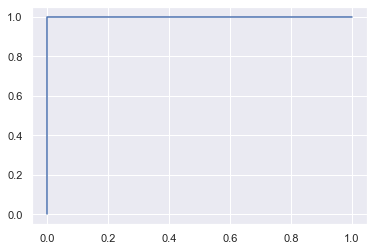

In [21]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, roc_curve, accuracy_score

tpr, fpr, thresolds = roc_curve(y_test, probabilities[:, 1])
plt.plot(tpr, fpr)
f1_score(y_test, predictions), recall_score(y_test, predictions), precision_score(y_test, predictions), accuracy_score(y_test, predictions)

In [22]:
t1 = time.perf_counter() - t0
print("Time elapsed: ", t1) # CPU seconds elapsed (floating point)

Time elapsed:  539.2387828999999


___

In some rare cases, the calculation of Precision or Recall can cause a division by 0. Regarding the precision, this can happen if there are no results inside the answer of an annotator and, thus, the true as well as the false positives are 0. For these special cases, we have defined that **if the true positives, false positives and false negatives are all 0, the precision, recall and F1-measure are 1**. This might occur in cases in which the gold standard contains a document without any annotations and the annotator (correctly) returns no annotations. **If true positives are 0 and one of the two other counters is larger than 0, the precision, recall and F1-measure are 0.**